In [14]:
import os
import json
import textwrap
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from termcolor import colored
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
rcParams["figure.figsize"] = 16, 10

from src.config import Config
from src.analysis.custom_dataset import Analysis
from src.analysis.custom_dataset import NewSummaryDataset
from src.analysis.custom_dataset import NewsSummaryDataModule

from src.train.t5_model import NewsSummaryModel

In [15]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(Config.MODELLING_CONFIG["MODEL_NAME"], 
                                        model_max_length=Config.ANALYSIS_CONFIG["MODEL_MAX_LENGTH"])

N_EPOCHS = 3
BATCH_SIZE = 8

In [16]:
analysis = Analysis()

In [17]:
analysis.reading_raw_news(tokenizer=tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (998 > 512). Running this sequence through the model will result in indexing errors


Reading Raw News Data:
  extract only the 'text' and 'ctext' from news summary dataframe...
  create train and test data from the raw news summary dataframe...
  calculating the counts of tokens of corpus from train data...
  done.


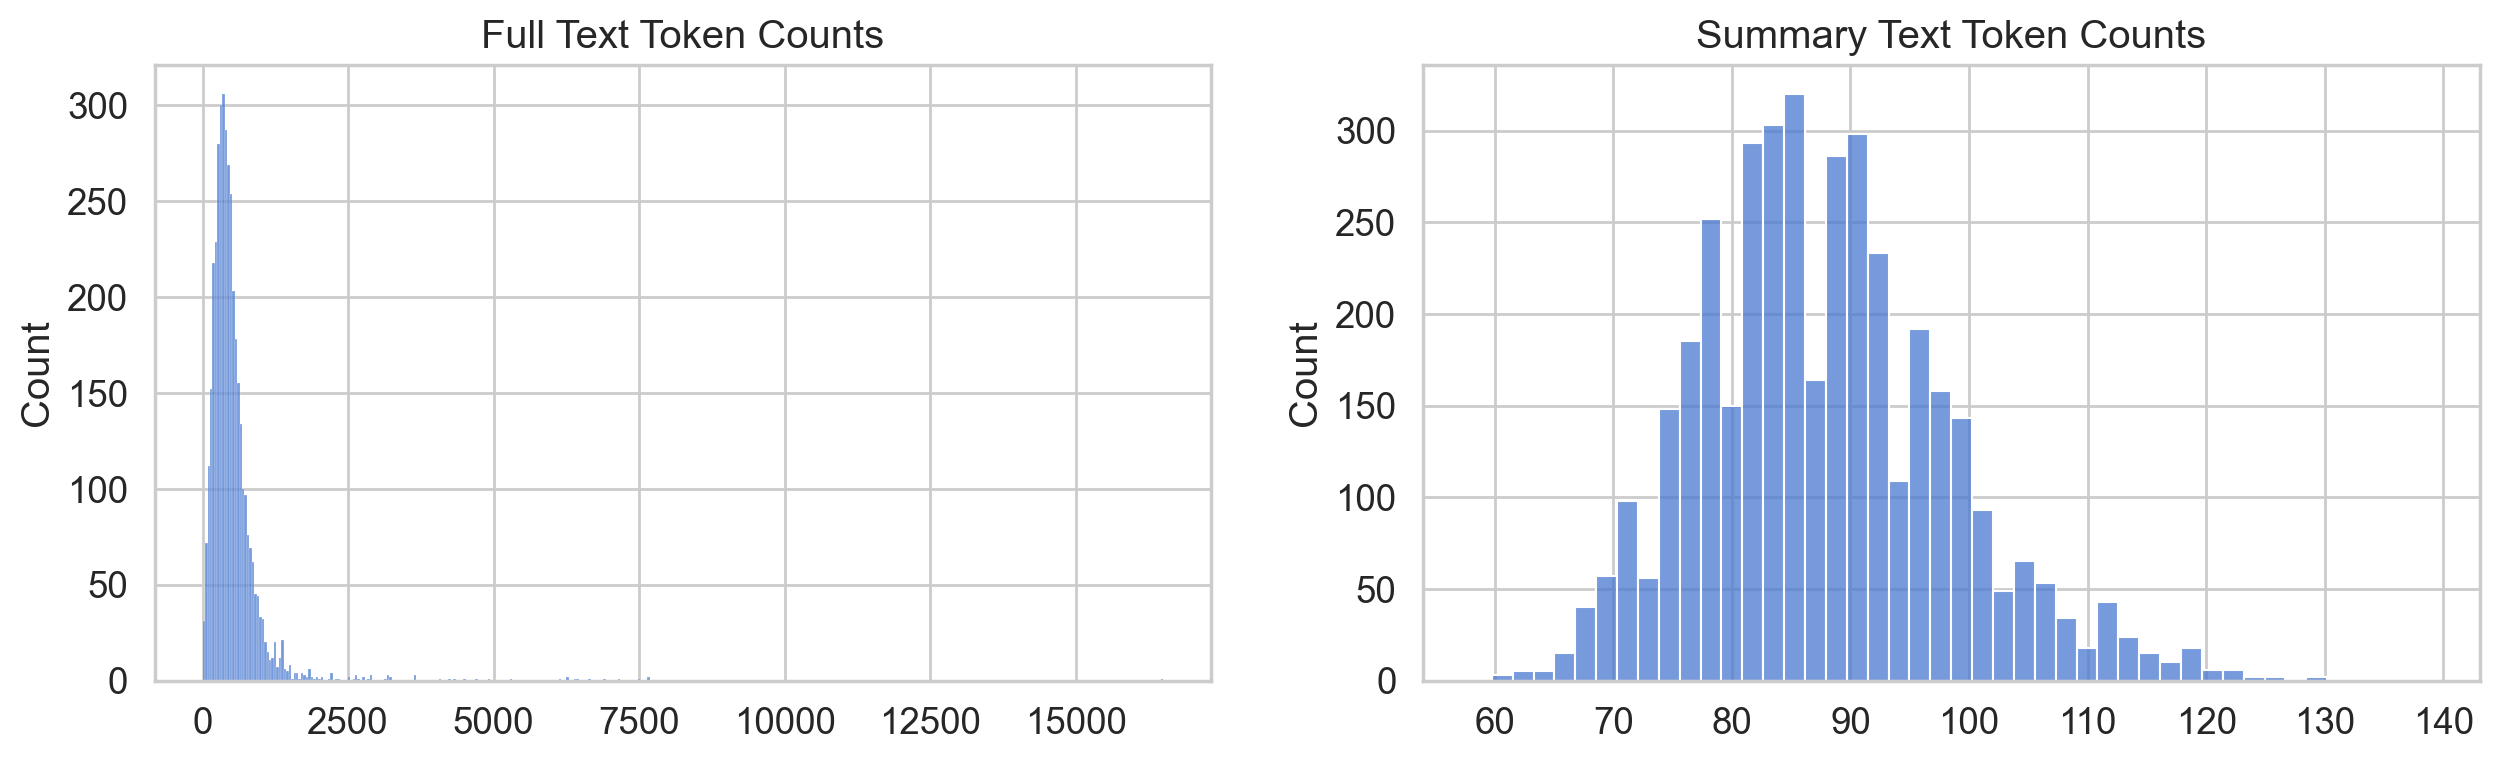

In [5]:
analysis.multi_histogram_plots(xvar1=analysis.text_token_counts, xvar2=analysis.summary_token_counts, 
                               title1="Full Text Token Counts", title2="Summary Text Token Counts")

In [6]:
data_module = NewsSummaryDataModule(train_df=analysis.data["train_df"], 
                                    test_df=analysis.data["test_df"], 
                                    tokenizer=tokenizer, 
                                    batch_size=analysis.ANALYSIS_CONFIG["BATCH_SIZE"],
                                    text_max_token_len=analysis.ANALYSIS_CONFIG["TEXT_MAX_TOKEN_LEN"],
                                    summary_max_token_len=analysis.ANALYSIS_CONFIG["SUMMARY_MAX_TOKEN_LEN"])

## Model

In [7]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
        
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        
        return output.loss, output.logits
    
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["text_input_d_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["text_input_d_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )
        
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["text_input_d_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )
        
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [8]:
model = NewsSummaryModel()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs --port=6006

In [10]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"   
)

logger = TensorBoardLogger("lightning_logs", name="news-summary")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
#     gpus=1,
    enable_progress_bar=True,
#     progress_bar_refresh_rate=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7:
    torch.set_float32_matmul_precision("medium")

In [13]:
data_module

In [12]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\12-News_Summarizer\summarizer_venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

NotImplementedError: Caught NotImplementedError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\12-News_Summarizer\summarizer_venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\12-News_Summarizer\summarizer_venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\12-News_Summarizer\summarizer_venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\12-News_Summarizer\summarizer_venv\lib\site-packages\torch\utils\data\dataset.py", line 53, in __getitem__
    raise NotImplementedError
NotImplementedError
